In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from snAPI.Main import *
import pandas as pd
sys.path.append("../")
from HH import HH_T3
from Functions import *
import time

NameError: name 'h' is not defined

In [2]:
def getcols(m1,nrows):
    arr=np.array([])
    for elem in np.cumsum(m1):
        rest=elem%(nrows)
        inte=elem//(nrows)
        if inte%2==1:
            a=nrows-rest
        else:
            a=rest 
        arr=np.append(arr,a)       
    return arr

In [3]:
filename='../../../Acquisition2/Data/Trial_markers/T/PTU_6.ptu'
#os.listdir(filename)

In [8]:
sn=snAPI()
sn.getDevice()
sn.getFileDevice(filename)
sn.initDevice(MeasMode.T3)
sn.unfold.measure()
times, channels = sn.unfold.getBlock()
dtimes=sn.unfold.dTime_T3(times)
markers_Bool=np.array([sn.unfold.isMarker(datai) for datai in channels])
m1=markers_Bool*sn.unfold.markers(channels)[1]
m2=markers_Bool*sn.unfold.markers(channels)[2]
m3=markers_Bool*sn.unfold.markers(channels)[3]
cum=np.cumsum(markers_Bool)
rm=np.array([n%2 for n in cum])
row=np.array(np.cumsum(m2),dtype=int)
df=pd.DataFrame(np.array([dtimes,times,channels,markers_Bool,m1,m2,m3,rm]).T,columns=['dTimes','absTimes','Channels','markers','m1','m2','m3','rm'])
df['row']=row
nrows=np.sum(df['m1'][df['row']==2])
col=np.array(getcols(m1,nrows),dtype=int)
df['col']=col

In [9]:
data= df[df['rm'] ==1]
data.drop(columns=['m1', 'm2','m3','markers','rm'])

,dTimes,absTimes,Channels,row,col
7,2132.0,3.421861e+10,131.0,0,1
8,24110.0,3.991436e+10,3.0,0,1
9,23398.0,6.352027e+10,3.0,0,1
10,17022.0,6.415180e+10,3.0,0,1
11,5680.0,6.480613e+10,3.0,0,1
...,...,...,...,...,...
14154,16890.0,6.279460e+13,3.0,9,0
14155,28148.0,6.280134e+13,3.0,9,0
14156,16886.0,6.280208e+13,3.0,9,0
14157,26762.0,6.280786e+13,3.0,9,0


In [10]:
xs=np.unique(df['row'])
ys=np.unique(df['col'])
M=np.zeros((np.size(xs),np.size(ys)))
for xi in xs:
    for yi in ys:
        M[xi,yi]=np.size(df['dTimes'][(df['row']==xi)&(df['col']==yi)])


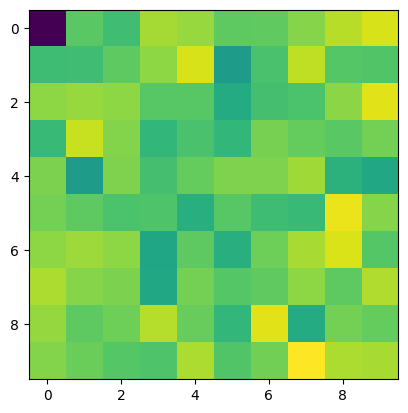

In [11]:
plt.imshow(M)